<a href="https://colab.research.google.com/github/P-shyam17/time_series/blob/main/Intro_to_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

acea_water_prediction_path = kagglehub.competition_download('acea-water-prediction')

print('Data source import complete.')


# Introduction
In this notebook, we will learn how to work with and predict time series. Time series are a collection of **time-dependent data** points. That means that each data point is assigned to a specific timestamp. Ideally, these data points are in chronological order and in contant time intervals (e.g. every minute or everyday). The time series forecasting problem **analyzes patterns in the past data to make predictions about the future**. The most popular example is probably stock price prediction. Other examples are sales of seasonal clothing or weather forecasts. In contrast to regression problems, time series are time-dependent and show specific characteristics, such as **trend and seasonality**.

**Overview**
* [Problem Definition](#Problem-Definition)<br>
* [Data Collection](#Data-Collection)<br>
* [Data Preprocessing](#Data-Preprocessing)<br>
    * [Chronological Order and Equidistant Timestamps](#[Chronological-Order-and-Equidistant-Timestamps])<br>
    * [Handling Missing Values](#Handling-Missing-Values)<br>
    * [Resampling](#Resampling)<br>
    * [Stationarity](#Stationarity)<br>
* [Feature Engineering](#Feature-Engineering)<br>
    * [Time Features](#Time-Features)<br>
    * [Decomposition](#Decomposition)<br>
    * [Lag](#Lag)<br>
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
    * [Autocorrelation Analysis](#Autocorrelation-Analysis)<br>
* [Cross Validation](#Cross-Validation)<br>
* [Models](#Models)<br>
    * [Models for Univariate Time Series](#Models-for-Univariate-Time-Series)<br>
        * [Naive Approach](#Naive-Approach)<br>
        * [Moving Average](#Moving-Average)<br>
        * [Exponential Smoothing  (IN WORK)](#MExponential-Smoothing)<br>
        * [ARIMA](#ARIMA)<br>
    * [Models for Multivariate Time Series](#Models-for-Multivariate-Time-Series)<br>
        * [Vector Autoregression (VAR)](#Vector-Autoregression)<br>

# Problem Definition
For this tutorial, we will build a model to predict the depth to groundwater of an aquifer located in Petrignano, Italy. The question we want to answer is
> What is the future depth to groundwater of a well belonging to the aquifier in Petrigrano over the next quarter?

> The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.

> Indeed, both rainfall and temperature affect features like level, flow, depth to groundwater and hydrometry some time after it fell down.

# Data Collection
In a typical workflow for time series, this would be the time for data collection. In this example, we will skip the data collection step and use data from the [Acea Smart Water Analytics challenge](https://www.kaggle.com/c/acea-water-prediction/). Therefore, this section will be a dataset overview.

Although the dataset contains multiple waterbodies, we will only be looking at the Aquifer_Petrignano.csv file.

Time series data usually comes in **tabular** format (e.g. csv files).

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../input/acea-water-prediction/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Since we are working with time series, the most essential features are the time related feature. In this example, we have the column `Date` which  uniquely identifies a day. Ideally, the data is already in chronological order and the time stamps are equidistant in time series. This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.


This column is provided in string format. Let's convert it to the `datetime64[ns]` data type.

In [ ]:
from datetime import datetime, date

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


Features:
* **Rainfall** indicates the quantity of rain falling (mm)
* **Temperature** indicates the temperature (°C)
* **Volume** indicates the volume of water taken from the drinking water treatment plant (m$^3$)
* **Hydrometry** indicates the groundwater level (m)

Target:
* **Depth to Groundwater** indicates the groundwater level (m from the ground floor)


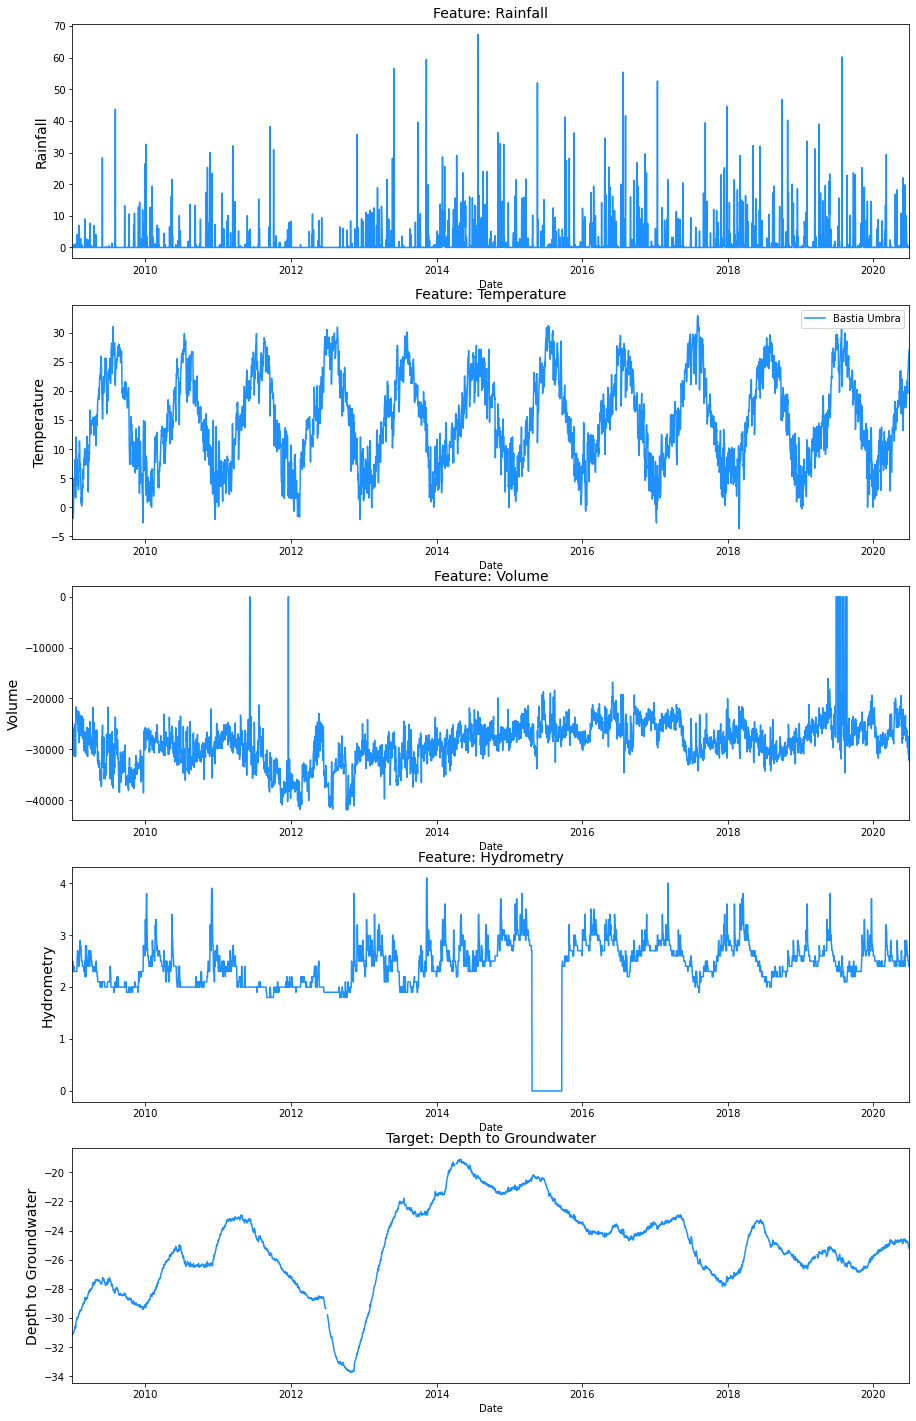

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

# Data Preprocessing

## Chronological Order and Equidistant Timestamps
The data should be in **chronological order** and the **timestamps should be equidistant** in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data (see [Resampling](#Resampling)).

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

In [ ]:
# Sort values by timestamp (not necessary in this case)
df = df.sort_values(by='Date')

# Check time intervals
df['Time_Interval'] = df.Date - df.Date.shift(1)

df[['Date', 'Time_Interval']].head()

In [ ]:
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

## Handling Missing Values

We can see that `Depth_to_Groundwater` has missing values.

Furthermore, plotting the time series reveals that there seem to be some **implausible zero values** for `Drainage_Volume`, and `River_Hydrometry`. We will have to clean them by replacing them by `nan` values and filling them afterwards.

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

Now we have to think about what to do with these missing values.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

* **Option 1: Fill NaN with Outlier or Zero**

    In this specific example filling the missing value with an outlier value such as -999 is not a good idea. However, many notebooks in this challenge have been using -999.
    
* **Option 2: Fill NaN with Mean Value**

    Also in this example, we can see that filling NaNs with the mean value is also not sufficient.

* **Option 3: Fill NaN with Last Value with `.ffill()`**

    Filling NaNs with the last value is already a little bit better in this case.

* **Option 4: Fill NaN with Linearly Interpolated Value with `.interpolate()`**

    Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring values.


In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

In [ ]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

## Resampling

Resampling can provide additional information on the data. There are two types of resampling:
* **Upsampling** is when the frequency of samples is increased (e.g. days to hours)
* **Downsampling** is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the `.resample()` function.

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))

ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df.Date, df.Temperature, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])
plt.show()

In this example, resampling would not be necessary. On the other hand, there is no necessity to look at the daily data. Considering weekly data seems to be sufficient as well. Therefore, we will **downsample the data to a weekly basis**.

In [ ]:
df_downsampled = df[['Date',
                     'Depth_to_Groundwater',
                     'Temperature',
                     'Drainage_Volume',
                     'River_Hydrometry'
                    ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                                ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

## Stationarity

Some time-series models, such as such as [ARIMA](#ARIMA), assume that the underlying data is stationary.
Stationarity describes that the time-series has
* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

> If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

Time series **with trend and/or seasonality are not stationary**. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

In [ ]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

The check for stationarity can be done via three different approaches:
1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

Let's do the **visual check** first. We can see that all features except `Temperature` have non-constant mean and non-constant variance. Therefore, **none of these seem to be stationary**. However, `Temperature` shows strong seasonality (hot in summer, cold in winter) and therefore it is not stationary either.

In [ ]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature, ax=ax[1, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry, ax=ax[0, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume, ax=ax[1, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater, ax=ax[2, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).mean(), ax=ax[2, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).std(), ax=ax[2, 0], color='blue', label='rolling std')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(3):
    ax[i,0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i,1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Next, we will **check the underlying statistics**. For this we will **split the time series into two sections** and check the mean and the variance. You could do more partitions if you wanted.

With this method, `Temperature` and `River_Hydrometry` show **somewhat similar (constant) mean and variance** and could be seen as stationary. However, with this method, we are not able to see the seasonality in the `Temperature` feature.

In [ ]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

In [ ]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

Let's evaluate the histograms. Since we are looking at the mean and variance, we are expecting that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity.

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.Temperature.fillna(np.inf), ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.River_Hydrometry.fillna(np.inf), ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.Drainage_Volume.fillna(np.inf), ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2, 0], color='indianred')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

**Augmented Dickey-Fuller (ADF) test**  is a type of statistical test called a unit root test.  Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: Time series has a unit root. (Time series is **not stationary**).

* **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is **stationary**).

If the **null hypothesis can be rejected**, we can conclude that the **time series is stationary**.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_Groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

In [ ]:

f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model that requires with characteristic, the data has to be transformed. However, if the data is not stationary to begin with, we should rethink the choice of model.

The two most common methods to achieve stationarity are:
* **Transformation**: e.g. log or square root to stabilize non-constant variance
* **Differencing**: subtracts the current value from the previous


In [ ]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['Depth_to_Groundwater_log'] = np.log(abs(df.Depth_to_Groundwater))

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
visualize_adfuller_results(abs(df.Depth_to_Groundwater), 'Absolute \n Depth to Groundwater', ax[0, 0])

sns.distplot(df.Depth_to_Groundwater_log, ax=ax[0, 1])
visualize_adfuller_results(df.Depth_to_Groundwater_log, 'Transformed \n Depth to Groundwater', ax[1, 0])

sns.distplot(df.Depth_to_Groundwater_log, ax=ax[1, 1])

plt.tight_layout()
plt.show()

Differencing can be done in different orders:
* First order differencing: linear trends with $z_i = y_i - y_{i-1}$
* Second-order differencing: quadratic trends with $z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$
* and so on...

In [ ]:
# First Order Differencing
ts_diff = np.diff(df.Depth_to_Groundwater)
df['Depth_to_Groundwater_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(df.Depth_to_Groundwater_diff_1)
df['Depth_to_Groundwater_diff_2'] = np.append([0], ts_diff)

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

visualize_adfuller_results(df.Depth_to_Groundwater_diff_1, 'Differenced (1. Order) \n Depth to Groundwater', ax[0])
visualize_adfuller_results(df.Depth_to_Groundwater_diff_2, 'Differenced (2. Order) \n Depth to Groundwater', ax[1])
plt.tight_layout()
plt.show()

The differencing can be reverted if the the first value before differencing is known. In this case, we can accumulate all values with the function `.cumsum()` and add the first value of the original time series.

In [ ]:
df.Depth_to_Groundwater.equals(df.Depth_to_Groundwater_diff_1.cumsum() + df.Depth_to_Groundwater.iloc[0])

# Feature Engineering

## Time Features

In [ ]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df.month%12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

## Encoding Cyclical Features
The new time features are cyclical. For example,the feature `month` cycles between 1 and 12 for every year.
While the difference between each month increments by 1 during the year, between two years the `month` feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df.Date, y=df.month, color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

Ideally, we want the underlying data to represent the same difference between two consecutive months, even between December and January. A common remedy for this issue is to encode cyclical features into two dimensions with sine and cosine transformation.

In [ ]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df.month/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df.month/month_in_year)

In [ ]:
days_in_month = 30
df['day_sin'] = np.sin(2*np.pi*df.day/days_in_month)
df['day_cos'] = np.cos(2*np.pi*df.day/days_in_month)

days_in_year = 365
df['day_of_year_sin'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
df['day_of_year_cos'] = np.cos(2*np.pi*df.day_of_year/days_in_year)

weeks_in_year = 52.1429
df['week_of_year_sin'] = np.sin(2*np.pi*df.week_of_year/weeks_in_year)
df['week_of_year_cos'] = np.cos(2*np.pi*df.week_of_year/weeks_in_year)

quarters_in_year = 4
df['quarter_sin'] = np.sin(2*np.pi*df.quarter/quarters_in_year)
df['quarter_cos'] = np.cos(2*np.pi*df.quarter/quarters_in_year)

seasons_in_year = 4
df['season_sin'] = np.sin(2*np.pi*df.season/seasons_in_year)
df['season_cos'] = np.cos(2*np.pi*df.season/seasons_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()


## Decomposition

The **characteristics of a time series** are
* Trend and Level
* Seasonality
* Random / Noise

We can use the function `seasonal_decompose()` from the [statsmodels](https://www.statsmodels.org) library.

* Additive: $y(t) = Level + Trend + Seasonality + Noise$
* Multiplicative: $y(t) = Level * Trend * Seasonality * Noise$

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols =  ['Rainfall', 'Temperature',
                   'Drainage_Volume',
                   'River_Hydrometry', 'Depth_to_Groundwater']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], freq=52, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df.Temperature, freq=52, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)
ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)
ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)
ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)
ax[3,0].set_ylim([-15, 15])

ax[0,1].set_title('Decomposition of Depth_to_Groundwater', fontsize=16)
res = seasonal_decompose(df.Depth_to_Groundwater, freq=52, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

plt.show()

In [ ]:
df[['Rainfall', 'Rainfall_trend', 'Rainfall_seasonal',
          'Temperature', 'Temperature_trend', 'Temperature_seasonal',
          'Drainage_Volume', 'Drainage_Volume_trend', 'Drainage_Volume_seasonal',
          'River_Hydrometry', 'River_Hydrometry_trend', 'River_Hydrometry_seasonal',
          'Depth_to_Groundwater', 'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal']].head()\
.style.set_properties(subset=['Rainfall_trend', 'Rainfall_seasonal',
                              'Temperature_trend', 'Temperature_seasonal',
                              'Drainage_Volume_trend', 'Drainage_Volume_seasonal',
                              'River_Hydrometry_trend', 'River_Hydrometry_seasonal',
                              'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal'
                             ], **{'background-color': 'dodgerblue'})

## Lag
`.shift()`



In [ ]:
weeks_in_month = 4

df['Temperature_seasonal_shift_r_2M'] = df.Temperature_seasonal.shift(-2*weeks_in_month)
df['Temperature_seasonal_shift_r_1M'] = df.Temperature_seasonal.shift(-1*weeks_in_month)
df['Temperature_seasonal_shift_1M'] = df.Temperature_seasonal.shift(1*weeks_in_month)
df['Temperature_seasonal_shift_2M'] = df.Temperature_seasonal.shift(2*weeks_in_month)
df['Temperature_seasonal_shift_3M'] = df.Temperature_seasonal.shift(3*weeks_in_month)

In [ ]:
df['Drainage_Volume_seasonal_shift_r_2M'] = df.Drainage_Volume_seasonal.shift(-2*weeks_in_month)
df['Drainage_Volume_seasonal_shift_r_1M'] = df.Drainage_Volume_seasonal.shift(-1*weeks_in_month)
df['Drainage_Volume_seasonal_shift_1M'] = df.Drainage_Volume_seasonal.shift(1*weeks_in_month)
df['Drainage_Volume_seasonal_shift_2M'] = df.Drainage_Volume_seasonal.shift(2*weeks_in_month)
df['Drainage_Volume_seasonal_shift_3M'] = df.Drainage_Volume_seasonal.shift(3*weeks_in_month)

df['River_Hydrometry_seasonal_shift_r_2M'] = df.River_Hydrometry_seasonal.shift(-2*weeks_in_month)
df['River_Hydrometry_seasonal_shift_r_1M'] = df.River_Hydrometry_seasonal.shift(-1*weeks_in_month)
df['River_Hydrometry_seasonal_shift_1M'] = df.River_Hydrometry_seasonal.shift(1*weeks_in_month)
df['River_Hydrometry_seasonal_shift_2M'] = df.River_Hydrometry_seasonal.shift(2*weeks_in_month)
df['River_Hydrometry_seasonal_shift_3M'] = df.River_Hydrometry_seasonal.shift(3*weeks_in_month)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_r_2M, label='shifted by -2 month', ax=ax, color='lightblue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_r_1M, label='shifted by -1 month', ax=ax, color='skyblue')

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, label='original', ax=ax, color='darkorange')

sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_1M, label='shifted by 1 month', ax=ax, color='dodgerblue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_2M, label='shifted by 2 month', ax=ax, color='blue')
sns.lineplot(x=df.Date, y=df.Temperature_seasonal_shift_3M, label='shifted by 3 month', ax=ax, color='navy')

ax.set_title('Shifted Time Series', fontsize=16)

ax.set_xlim([date(2017, 6, 30), date(2020, 6, 30)])
ax.set_ylabel(ylabel='Temperature Bastia Umbra', fontsize=14)

plt.show()

# Exploratory Data Analysis

Let's begin by plotting the seasonal components of each feature and comparing the minima and maxima. By doing this, we can already gain some insights:
* The depth to groundwater reaches its maximum around May/June and its minimum around November/December
* The temperature reaches its maxmium around August and its minimum around January
* The volume reaches its maximum around June and its minimum around August/September. It takes longer to reach its maximum than to reach its minimum.
* The hydrometry reaches its maximum around March and its minimum around September

* The volume and hydrometry reach their minimum roughly around the same time
* The volume and hydrometry reach their minimum when the temperature reaches its maximum
* Temperature lags begind depth to groundwater by around 2 to 3 months

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater_seasonal, ax=ax[0], color='dodgerblue', label='P25')
ax[0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, ax=ax[1], color='dodgerblue', label='Bastia Umbra')
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume_seasonal, ax=ax[2], color='dodgerblue')
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry_seasonal, ax=ax[3], color='dodgerblue')
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Rainfall_seasonal, ax=ax[4], color='dodgerblue')
ax[4].set_ylabel(ylabel='Rainfall', fontsize=14)

for i in range(5):
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

We can see that the correlation to the target variables increases if we use the time shifted features in comparison to the original features.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

original_cols = ['Depth_to_Groundwater_seasonal',
                 'Temperature_seasonal',
                 'Drainage_Volume_seasonal', 'River_Hydrometry_seasonal']

corrmat = df[original_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Original Features', fontsize=16)

shifted_cols = [ 'Depth_to_Groundwater_seasonal',
                'Temperature_seasonal_shift_r_2M',
                'Drainage_Volume_seasonal_shift_1M', 'River_Hydrometry_seasonal_shift_3M']
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Shifted Features', fontsize=16)


plt.tight_layout()
plt.show()

## Autocorrelation Analysis

<div class="alert alert-block alert-info">
    For further details on this topic, see my other notebook:
    <a href="https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf">Time Series: Interpreting ACF and PACF</a>
</div>



This EDA step is especially important when using [ARIMA](#ARIMA). The autocorrelation analysis helps to identify the AR and MA parameters for the [ARIMA](#ARIMA) model.

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

* **Autocorrelation  Function (ACF)**: Correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1. -> <font color='blue'>MA parameter is q significant lags</font>
* **Partial Autocorrelation Function (PACF)**: Additional correlation explained by each successive lagged term -> <font color='purple'>AR parameter is p significant lags</font>

Autocorrelation helps in detecting seasonality.

As we can infer from the graph above, the autocorrelation continues to decrease as the lag increases, confirming that there is no linear association between observations separated by larger lags.

For the AR process, we expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. To define a MA process, we expect the opposite from the ACF and PACF plots, meaning that: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend.

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Depth_to_Groundwater_diff_1)
plt.show()

We can see some sinusoidal shape in both ACF and PACF functions. This suggests that both AR and MA processes are present.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df.Depth_to_Groundwater_diff_1,lags=100, ax=ax[0])
plot_pacf(df.Depth_to_Groundwater_diff_1,lags=100, ax=ax[1])
plt.show()

In [ ]:
"""
## Spectral Analysis
to analyse cyclic behavior
Frequency domain analysis

## Trend estimation and decomposition
used for seasonal adjustment
"""

# Cross Validation

For cross validation, you can use the [Time Series Split](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) library.
In [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition), I go into depth about different types of time series problems and their cross validation methods.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df.Date
y = df.Depth_to_Groundwater

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

# Models

Time series can be either **univariate or multivariate**:
* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, by only looking at the target variable `Depth to Groundwater` we can convert it to a univariate time series.

We will focus on a **quarterly forecast**. We will use the **Q2 2020 as test data** and the remaining data will be **split by quarter for cross validation**.

We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models. For metrics are better the smaller they are.



## Models for Univariate Time Series

* Stochastic Models
    * [Naive Approach](#Naive-Approach)<br>
    * [Moving Average](#Moving-Average)<br>
    * [Exponential Smoothing](#MExponential-Smoothing)<br>
    * [ARIMA](#ARIMA)<br>
    * [Prophet](#Prophet)<br>
* Deep Learning
    * [LSTM](#LSTM)<br>
    * [GRU](#GRU)<br>

In [ ]:
df['quarter_idx'] = (df.quarter != df.quarter.shift(1)).cumsum()

target = 'Depth_to_Groundwater'
features = [feature for feature in df.columns if feature != target]

N_SPLITS = 46

X = df[df.quarter_idx < N_SPLITS][features]
y = df[df.quarter_idx < N_SPLITS][target]

X_test = df[df.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df[df.quarter_idx == N_SPLITS][target].reset_index(drop=True)

In [ ]:
folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='train')
sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='darkorange', label='test')

sns.lineplot(x=df.Date, y=df.quarter_idx, ax=ax[1], color='dodgerblue')
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].set_ylim([0, N_SPLITS+1])
#ax[0].set_ylim([-28, -23])

plt.show()

In [ ]:
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2) #navajowhite
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Depth to Groundwater P25', fontsize=14)

    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])#marker='o',
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 4])
    plt.show()

### Naive Approach

$\hat y_{t+1} = y_t$

In [ ]:
score_mae = []
score_rsme = []
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))

    # Prediction: Naive approach
    y_valid_pred = y_valid_pred * y_train.iloc[-1]

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach')

### Moving Average

In [ ]:
score_mae = []
score_rsme = []
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    #X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Initialize y_valid_pred
    y_valid_pred = pd.Series(np.ones(len(y_valid)))

    # Prediction: Naive approach
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train.append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.zeros(len(X_test)))

for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 4 Weeks)')

Neither the Naive Approach nor the Moving Average Approach are yielding good results for our example. Usually, these approaches serve as a benchmark rather than the method of choice.

### ARIMA
The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
* <font color='purple'>Auto-Regressive (AR) filter (long term)</font>:
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Integration filter (stochastic trend)</font>
    
    -> d
* <font color='blue'>Moving Average (MA) filter (short term)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}}
+ \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Lag order (to determine see  PACF in [Autocorrelation Analysis](#Autocorrelation-Analysis))
* <font color='orange'>d</font>: Degree of differencing. (to determine see  Differencing in [Stationarity](#Stationarity))
* <font color='blue'>q</font>: Order of moving average (to determine see  ACF in [Autocorrelation Analysis](#Autocorrelation-Analysis))

In our example, we can use <font color='orange'>d=0</font> if we use the feature `Depth_to_Groundwater_diff_1`, which is `Depth_to_Groundwater` differenced by the first degree. Otherwise, if we were to use the non-stationary feature `Depth_to_Groundwater` as it is, we should set <font color='orange'>d=1</font>.

(work in progress...)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Fit model with Vector Auto Regression (VAR)
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()

    # Prediction with Vector Auto Regression (VAR)
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))


# Fit model with Vector Auto Regression (VAR)
model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')

## Models for Multivariate Time Series

### Vector Auto Regression (VAR)

In [ ]:
from statsmodels.tsa.api import VAR

score_mae = []
score_rsme = []

features = ['Temperature', 'Drainage_Volume', 'River_Hydrometry','Rainfall' ]
for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    X_train, X_valid = X.iloc[train_index][features], X.iloc[valid_index][features]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Fit model with Vector Auto Regression (VAR)
    model = VAR(pd.concat([y_train, X_train], axis=1))
    model_fit = model.fit()

    # Prediction with Vector Auto Regression (VAR)
    y_valid_pred = model_fit.forecast(model_fit.y, steps=len(X_valid))
    y_valid_pred = pd.Series(y_valid_pred[:, 0])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Fit model with Vector Auto Regression (VAR)
model = VAR(pd.concat([y, X[features]], axis=1))
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
y_pred = model_fit.forecast(model_fit.y, steps=len(X_valid))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')

# Additional Ressources

## My Time Series Forecasting Series

* [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
* [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition)
* [Time Series Forecasting: Interpreting ACF and PACF](https://www.kaggle.com/iamleonie/time-series-interpreting-acf-and-pacf)
* [Time Series Forecasting: Tips & Tricks for Training LSTMs](https://www.kaggle.com/iamleonie/time-series-tips-tricks-for-training-lstms)

## Other Ressources
Here are some additional ressources that helped me learn about time series
* [Getting started with Time Series using Pandas ](https://www.kaggle.com/parulpandey/getting-started-with-time-series-using-pandas)
* [Time Series Analysis || An Introductory Start](https://www.kaggle.com/janiobachmann/time-series-analysis-an-introductory-start)
* [Everything you can do with a time series](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series)
* [Deep Learning for Time Series | Dimitry Larko | Kaggle Days](https://www.youtube.com/watch?v=svNwWSgz2NM)
* [Encoding Cyclical Features for Deep Learning](https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning)
* [Tamara Louie: Applying Statistical Modeling & Machine Learning to Perform Time-Series Forecasting](https://www.youtube.com/watch?v=JntA9XaTebs)
* [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
* [Easy Guide on Time Series Forecasting](https://beingdatum.com/time-series-forecasting/)

# Useful Libraries
* [statsmodels](https://www.statsmodels.org)
* [Pandas Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
* [Time Series Split](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)

In [ ]:
"""
### Exponential Smoothing
based on a description of the **trend and seasonality** in the data

### Prophet

### LSTM

### GRU

(work in progress)

Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)

Recurrent Neural Network (RNN)
"""